# Cardiac MRI Segmentation

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/CMRI/code/Segmentation'

/content/drive/.shortcut-targets-by-id/1Tbi0Qtohtx7tBgxq_Q2_iL22GLPh67IH/CMRI/code/Segmentation


In [ ]:
%ls

 Experiments/  'U-Net 2D Segmentation Final.ipynb'


In [ ]:
dataset_dir = '/content/drive/MyDrive/CMRI/training ED'

In [ ]:
import os
import pickle

In [ ]:
with open(os.path.join(dataset_dir, 'train.pickle'), 'rb') as f:
  train_data = pickle.load(f)
  del train_data['y_processed']

with open(os.path.join(dataset_dir, 'val.pickle'), 'rb') as f:
  test_data = pickle.load(f)
  del test_data['y_processed']

## Visualize Images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def highlight_classes(image, mask):
    # Define colors for each class
    class_colors = {
        1: 0,    # Right Ventricle
        2: 127.5,    # Myocardium
        3: 255,    # Left Ventricle
    }

    # convert mask labels to integer
    mask = mask.astype(int)

    # Create a new image for visualization
    visualized_image = np.copy(image)

    # Loop through each pixel in the mask
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            pixel_class = mask[row, col]

            # Check if the pixel class is 0-2
            if pixel_class in class_colors.keys():
                # Get the corresponding color for the class
                color = class_colors[pixel_class]

                # Highlight the pixel in the visualized image
                visualized_image[row, col] = color

    return visualized_image

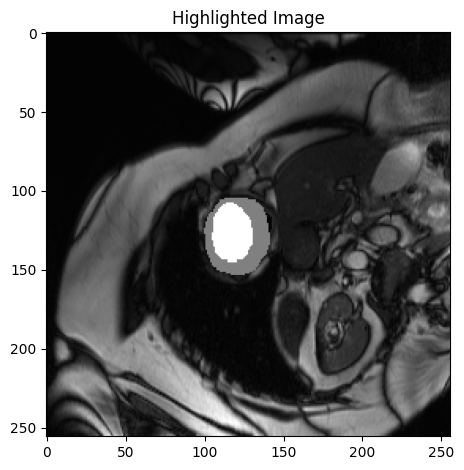

In [ ]:
# Load your image and mask
idx = 5
image = train_data['x'][idx]
mask = train_data['y'][idx]

# Call the function to generate the highlighted image
highlighted_image = highlight_classes(image, mask)

# Display highlighted image
plt.imshow(highlighted_image, cmap='gray')
plt.title("Highlighted Image")

plt.tight_layout()
plt.show()

## Preprocess Image/Label

In [ ]:
from keras.utils import to_categorical

In [ ]:
x_train = np.expand_dims(train_data['x'] / 255, -1)
x_test = np.expand_dims(test_data['x'] / 255, -1)
y_train = to_categorical(train_data['y'], num_classes=4)
y_test = to_categorical(test_data['y'], num_classes=4)

In [ ]:
x_train.shape

(763, 256, 256, 1)

## Build U-Net Architecture

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

def UNET(input_shape, input_channels, num_classes):
    inputs = Input(shape=(input_shape[0], input_shape[1], input_channels))

    # Encoder path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom of the U shape
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder path
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer with the number of classes defined
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = UNET((256, 256), 1, 4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

## Training Model

In [ ]:
from keras.callbacks import ModelCheckpoint

In [ ]:
callback = ModelCheckpoint(filepath="cardiac_mri_segmenter.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=16, epochs=15, callbacks=[callback])

Epoch 1/15
48/48 [==============================] - ETA: 0s - loss: 0.3670 - accuracy: 0.9469
Epoch 1: val_loss improved from inf to 0.13982, saving model to cardiac_mri_segmenter.h5
48/48 [==============================] - 105s 1s/step - loss: 0.3670 - accuracy: 0.9469 - val_loss: 0.1398 - val_accuracy: 0.9706
Epoch 2/15
48/48 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9671
Epoch 2: val_loss improved from 0.13982 to 0.13423, saving model to cardiac_mri_segmenter.h5
48/48 [==============================] - 47s 989ms/step - loss: 0.1556 - accuracy: 0.9671 - val_loss: 0.1342 - val_accuracy: 0.9706
Epoch 3/15
48/48 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9671
Epoch 3: val_loss improved from 0.13423 to 0.12255, saving model to cardiac_mri_segmenter.h5
48/48 [==============================] - 44s 917ms/step - loss: 0.1407 - accuracy: 0.9671 - val_loss: 0.1226 - val_accuracy: 0.9706
Epoch 4/15
48/48 [==============================]

## Model Evaluation

In [ ]:
history = model.history.history

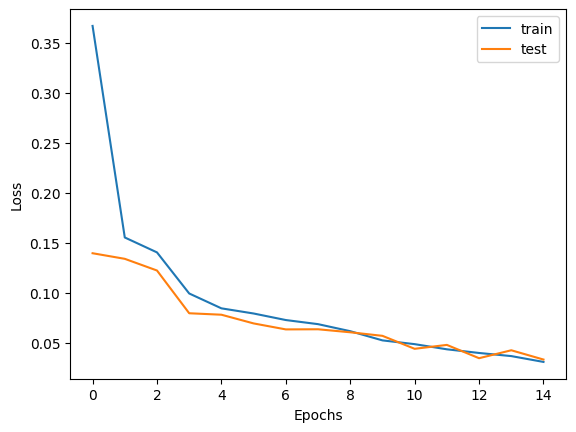

In [ ]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Loss Learning Curve')
plt.show()

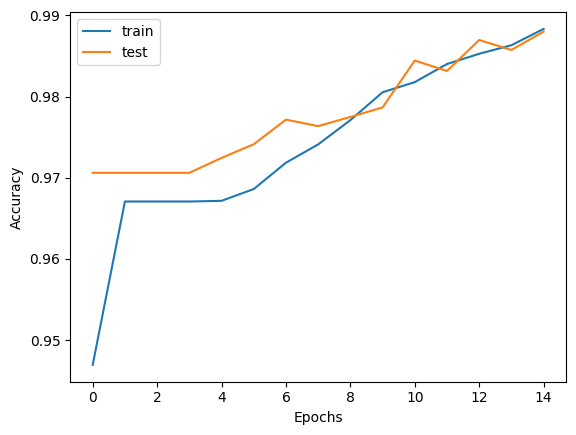

In [ ]:
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy Learning Curve')
plt.show()

## Test Inference

In [ ]:
from keras.models import load_model
import random

In [ ]:
saved_model = load_model('cardiac_mri_segmenter.h5')

In [ ]:
y_pred = saved_model.predict(x_test)

7/7 [==============================] - 3s 454ms/step


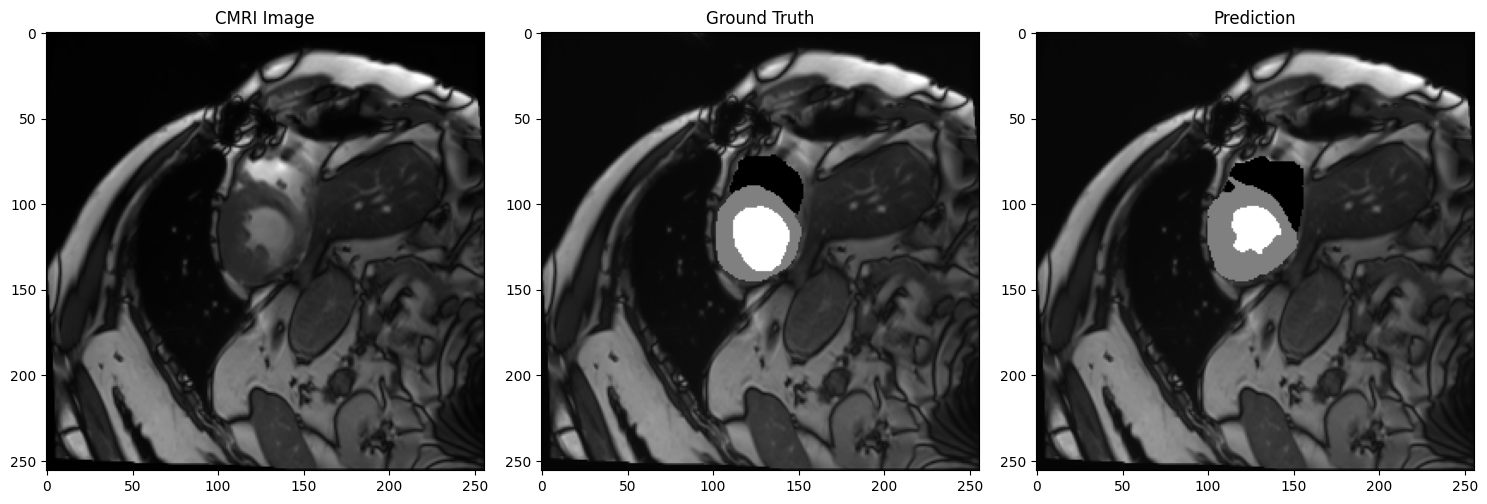

In [ ]:
# Generate random index from testing set
idx = random.randint(0, len(y_pred) - 1)
# Load your image and mask
image = np.squeeze(x_test[idx] * 255)
pred = np.argmax(y_pred[idx], axis=2)
label = np.argmax(y_test[idx], axis=2)

# Call the function to generate the highlighted image
ground_truth = highlight_classes(image, label)
prediction = highlight_classes(image, pred)

# Display highlighted image
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("CMRI Image")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(prediction, cmap='gray')
plt.title("Prediction")

plt.tight_layout()
plt.show()